# Example Application: Defect Detection of Workpieces in a Casting Manufacturing Process. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/example_defect_casting.ipynb
[2]:https://docs.masterfulai.com/0.5.2/notebooks/example_defect_casting.ipynb

In this guide you'll rapidly build a binary classifier to detect defects in a manufacturing process. Each workpiece is created using a casting manufacturing process, in which molten metal is poured into a mold. 

You have been tasked with building a solution to satisfy the following user story:

```
As a plant manager,
I want to automatically detect defects in my workpieces,
so that I can deploy it alongside my existing manual QC process to reduce my plant's defect rate. 
```

Your first task is to acquire data. Normally, you'd have to get up from your desk and start snapping photos with your phone, or install a camera over an assembly line and feed it to a server. For the purposes of this example, you'll use an existing data set. 

## Acquiring Data

Go to kaggle.com and register an account. Follow [these instructions][21] to acquire a Kaggle API Token and save it to ~/.kaggle/kaggle.json. Install kaggle via pip, then download the dataset and unzip it, then get rid of the zip file. The data we care about it is in `./casting_512x512/casting_512x512`. The two subdirectorys are `def_front` and `ok_front`, corresponding to defective and okay workpieces. 

[21]: https://www.kaggle.com/docs/api

In [2]:

!mkdir ~/.kaggle
!echo "{\"username\":\"YOUR_USERNAME\",\n\"key\":\"YOUR_KEY\"}" > ~/.kaggle/kaggle.json

In [3]:
import sys
!{sys.executable} -m pip install --upgrade pip --quiet
!{sys.executable} -m pip install kaggle --quiet
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product
!ls *.zip
!unzip -q -o real-life-industrial-dataset-of-casting-product.zip 

## Exploratory Data Analysis

Next, it's always important to perform EDA to search for any anomolies, errors, and to develop an intuition for your images and labels. As a bare minimum, visulize some OK and DEFective examples. The similarity of these images indicates that this dataset is low entropy, which would normally make hyperparameter tuning difficult. However, Masterful automatically handles hyperparameter tuning, so you will have no problems working with this low-entropy dataset. 

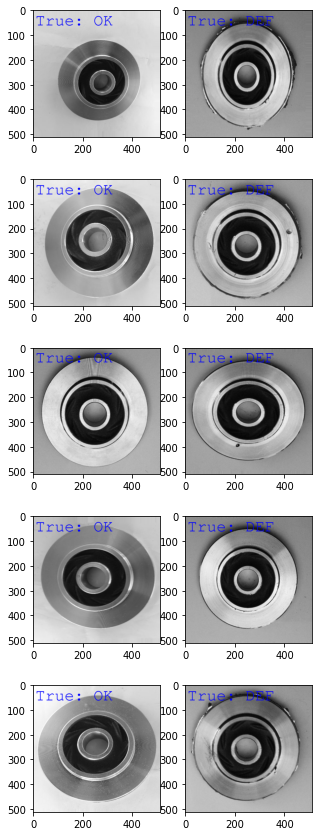

In [4]:
import matplotlib.pyplot as plt
import PIL, PIL.ImageDraw, PIL.ImageFont
import requests
from io import BytesIO

ok = [
    "./casting_512x512/casting_512x512/ok_front/cast_ok_0_1018.jpeg",
    "./casting_512x512/casting_512x512/ok_front/cast_ok_0_1021.jpeg",
    "./casting_512x512/casting_512x512/ok_front/cast_ok_0_1028.jpeg",
    "./casting_512x512/casting_512x512/ok_front/cast_ok_0_1074.jpeg",
    "./casting_512x512/casting_512x512/ok_front/cast_ok_0_1082.jpeg",
]

def_ = [
    "./casting_512x512/casting_512x512/def_front/cast_def_0_0.jpeg",
    "./casting_512x512/casting_512x512/def_front/cast_def_0_100.jpeg",
    "./casting_512x512/casting_512x512/def_front/cast_def_0_1015.jpeg",
    "./casting_512x512/casting_512x512/def_front/cast_def_0_102.jpeg",
    "./casting_512x512/casting_512x512/def_front/cast_def_0_1046.jpeg",
]

images = [ok, def_]
ROWS = 5
COLUMNS = len(images)

f, axarr = plt.subplots(ROWS, COLUMNS, figsize=(5,15))
curr_row = 0

for col, image_col, true in ((0, ok, 'OK'), (1, def_, 'DEF')):
    for row, image_row in enumerate(image_col):
        with PIL.Image.open(image_row) as image:
            drawing = PIL.ImageDraw.Draw(image)
            font = PIL.ImageFont.truetype('FreeMono.ttf', 65)
            drawing.text((10, 10), f'True: {true}', font=font, fill =(0, 0, 255))
            axarr[row, col].imshow(image)

## Creating Labels

You'll use the Masterful CLI Trainer to quickly train a model to state of the art performance. By using Masterful, you'll avoid lots of the tedious parts of deep learning: setting up data processing pipelines, implementing architectures, and fiddling with hyperparameters. In fact, you may be able to avoid using experiment tracking tools entirely because Masterful automatically runs experiments to tune hyperparameters related to optimization, data augmentation, and regularization. 

The Masterful [label format][30] is a simple CSV structure. Each row is a relative path, followed by an integer corresponding to a label. A second labelmap file maps those integers to short text descriptions. 

Let's generate and then examine a few lines of the csv.

[30]: ../markdown/guide_cli_data_directory_format.md

In [5]:
import os

OK_PATH = './casting_512x512/casting_512x512/ok_front/'
DEF_PATH = './casting_512x512/casting_512x512/def_front/'

ok = os.listdir(OK_PATH)
def_ = os.listdir(DEF_PATH)

print(f'num ok images: {len(ok)}. Using 10% for test: {len(ok)//10}')
print(f'num def images: {len(def_)}. Using 10% for test: {len(def_)//10}')

with open('test.csv', 'w') as f:
  for path in ok[:len(ok)//10]:
    f.write(OK_PATH + path + ',0\n')

  for path in def_[:len(def_)//10]:
    f.write(DEF_PATH + path + ',1\n')
    
with open('train.csv', 'w') as f:
  for path in ok[len(ok)//10:]:
    f.write(OK_PATH + path + ',0\n')

  for path in def_[len(def_)//10:]:
    f.write(DEF_PATH + path + ',1\n')



num ok images: 519. Using 10% for test: 51
num def images: 781. Using 10% for test: 78


In [6]:
!head train.csv

./casting_512x512/casting_512x512/ok_front/cast_ok_0_6471.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_5852.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_4503.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_1761.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_9634.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_7112.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_1879.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_6306.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_3371.jpeg,0
./casting_512x512/casting_512x512/ok_front/cast_ok_0_8002.jpeg,0


Finally, create a simple label_map csv file, marking each image as OK or DEF (for defective). 

In [7]:
! echo -e "0, ok \n 1, def" > label_map.csv

## YAML Config File for Masterful CLI Trainer

Now, you'll setup the YAML config file. This config file is very sparse compared to YAML files you might have worked with in the past because the CLI Trainer is **goal oriented**. It is not simply wrapping a low level Python API in YAML - the CLI Trainer only needs to understand the goals for your model. Its internal automation handles the process of setting up data pipelines, training, regularization, evaluation, and saving the model. 

The main decision you need to make in the config is which model architecture to train with. The decision on model architecture is a trade-off between inference speed and accuracy. The bigger the model, the slower and more expensive it will be to run in inference, but the more accurate it will be. 

For a first training run, starting with the smallest possible model allows you to iterate more quickly. Then, once you have a trained model, you can experiment with larger models. One of the smallest available models is mobilenetv3_small. 

```yaml
dataset:
  root_path: .
  splits: [train, test]
  label_map: label_map

model:
  architecture: mobilenetv3_small
  num_classes: 1
  input_shape: [512,512,3]

training:
  task: binary_classification
  training_split: train

output:
  formats: [saved_model]
  path: ~/model_output

evaluation:
  split: test
```

In [8]:
!touch config.yaml
!echo  "dataset:" > config.yaml
!echo  "  root_path: ." >> config.yaml
!echo  "  splits: [train, test]" >> config.yaml
!echo  "  label_map: label_map" >> config.yaml
!echo  "model:" >> config.yaml
!echo  "  architecture: mobilenetv3_small" >> config.yaml
!echo  "  num_classes: 1" >> config.yaml
!echo  "  input_shape: [512,512,3]" >> config.yaml
!echo  "training:" >> config.yaml
!echo  "  task: binary_classification" >> config.yaml
!echo  "  training_split: train" >> config.yaml
!echo  "output:" >> config.yaml
!echo  "  formats: [saved_model]" >> config.yaml
!echo  "  path: ~/model_output" >> config.yaml
!echo  "evaluation:" >> config.yaml
!echo  "  split: test" >> config.yaml

!cat config.yaml

dataset:
  root_path: .
  splits: [train, test]
  label_map: label_map
model:
  architecture: mobilenetv3_small
  num_classes: 1
  input_shape: [512,512,3]
training:
  task: binary_classification
  training_split: train
output:
  formats: [saved_model]
  path: ~/model_output
evaluation:
  split: test


## Train

You are ready to train. Notice that you did NOT have to worry about:

* Augmenting data with slow OpenCV / PIL CPU based transforms
* Figuring out hyperparameters for regularization methods
* Trying to implement state of the art augmentations
* Tuning your learning rate and batch size and optimizer to make the most of your GPU

The training run will take about an hour on an Nvidia V100 GPU. 

Once training is complete, the CLI will print out evaluation metrics and save the model to disk at model_ouput. You'll have everything you need to see if the model meets your acceptance criteria. 


In [9]:
!{sys.executable} -m pip install -U masterful --quiet
!masterful-train --config=config.yaml

Loaded Masterful version 0.5.2. This software is distributed free of charge for
personal use. Register in the next 40 days to continue using Masterful.
Visit http://www.masterfulai.com/register for more details.

MASTERFUL [13:27:57]: Training with configuration 'config.yaml':
----------  -------------------------------------
dataset     root_path  .
            splits     ['train', 'test']
            label_map  label_map
model       architecture  mobilenetv3_small
            num_classes   1
            input_shape   [512, 512, 3]
training    task            binary_classification
            training_split  train
output      formats  ['saved_model']
            path     ~/model_output
evaluation  split  test
----------  -------------------------------------
MASTERFUL [13:27:58]: Building model 'mobilenetv3_small'...
MASTERFUL [13:27:59]: Using model mobilenetv3_small with:
MASTERFUL [13:27:59]:     1530993 total parameters
MASTERFUL [13:27:59]:     1518881 trainable parameters
MASTER

As you can see, you've trained a very accurate model. It is delivering around 99% on accuracy, as well as precision and recall. Let's see how the model predicts on the sample images we explored earlier. To load models from disk, follow the instructions in the [guide to inference][22].

[22]: ../markdown/guide_cli_model_output_formats.md#how-to-load-a-saved-model-in-tensorflow

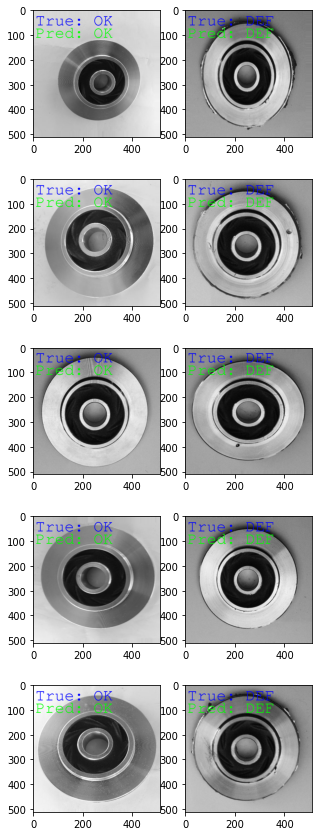

In [10]:
import os
import tensorflow as tf

model = tf.keras.models.load_model(f'{os.path.expanduser("~")}/model_output/session-00019/saved_model')
inference_func = model.signatures["serving_default"]

def predict(image):
    image =  tf.convert_to_tensor(image)

    logit = inference_func(image=image)['prediction']
    # BUG: Up to 0.5.2, the output of this model is a logit:
    # * Positive corresponds to any value greater than zero. 
    # * Negative corresponds to any value less than zero. 
    # 
    # Starting in 0.5.3, the output of this model will be in the range [0, 1]:
    # * Positive generally corresponds to any value greater than 0.5.
    # * Negative generally will correspond to any value less than 0.5.
    pred = tf.nn.sigmoid(logit)
    pred = pred[0][0]
    return 'OK' if pred < 0.5 else 'DEF'

f, axarr = plt.subplots(ROWS, COLUMNS, figsize=(5,15))
curr_row = 0

for col, image_col, true in ((0, ok, 'OK'), (1, def_, 'DEF')):
    for row, image_row in enumerate(image_col):
        with PIL.Image.open(image_row) as image:
            pred = predict(image)
            
            drawing = PIL.ImageDraw.Draw(image)
            font = PIL.ImageFont.truetype('FreeMono.ttf', 65)
            drawing.text((10, 10), f'True: {true}', font=font, fill =(0, 0, 255))
            drawing.text((10, 60), f'Pred: {pred}', font=font, fill =(0, 255, 0))
            axarr[row, col].imshow(image)

## Deployment

Now that you have a trained model, it's time to start thinking about how you'll integrate it with an application that your quality inspection staff will use. In your case, assume you've decided to hand out Apple iPhones to your quality inspectors. Look into [Apple's SDK to integrate Tensorflow Models with iOS apps][11] to get started packaging your model into an app for your quality inspectors. 

[11]: https://developer.apple.com/documentation/coreml